### Importacao das bibliotecas

In [3]:

import time

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

matplotlib.rcParams["contour.negative_linestyle"] = "solid"

In [1]:
# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

In [3]:
# define outlier/anomaly detection methods to be compared.
# the SGDOneClassSVM must be used in a pipeline with a kernel approximation
# to give similar results to the OneClassSVM
anomaly_algorithms = [
    
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
    (
        "One-Class SVM (SGD)",
        make_pipeline(
            Nystroem(gamma=0.1, random_state=42, n_components=150),
            SGDOneClassSVM(
                nu=outliers_fraction,
                shuffle=True,
                fit_intercept=True,
                random_state=42,
                tol=1e-6,
            ),
        ),
    ),
    (
        "Isolation Forest",
        IsolationForest(contamination=outliers_fraction, random_state=42),
    ),
]


In [4]:
# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, 0.3], **blobs_params)[0],
    4.0
    * (
        make_moons(n_samples=n_samples, noise=0.05, random_state=0)[0]
        - np.array([0.5, 0.25])
    ),
    14.0 * (np.random.RandomState(42).rand(n_samples, 2) - 0.5),
]


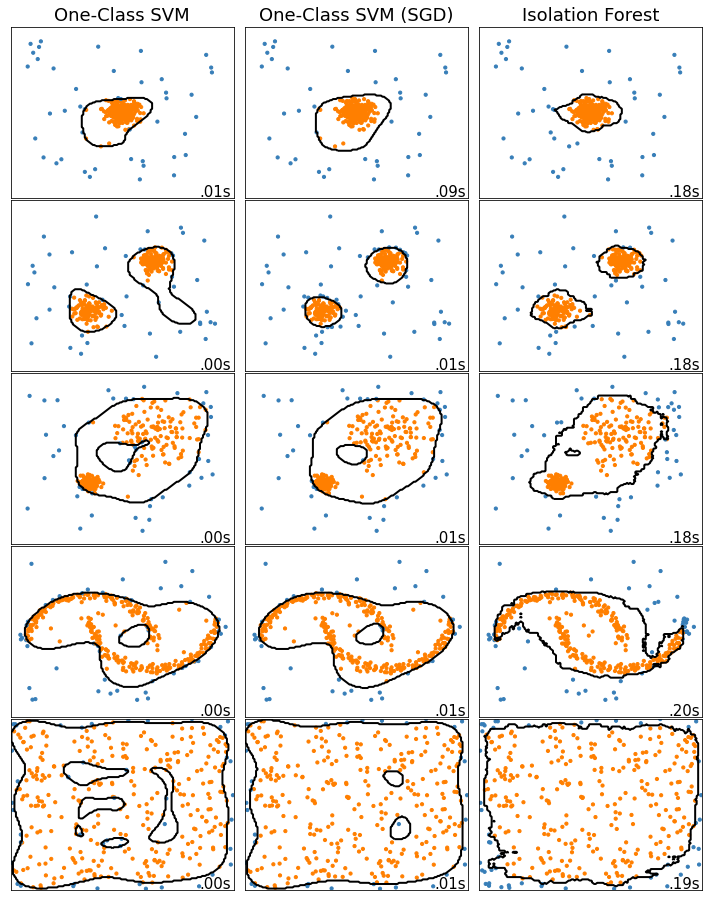

In [10]:
# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 4, 12.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")

        colors = np.array(["#377eb8", "#ff7f00"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

## OUTRO BANCO DE DADOS

In [19]:
df = pd.read_csv('Xeek_Well_15-9-15.txt')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13290 entries, 4371 to 17707
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   WELL       13290 non-null  object 
 1   DEPTH_MD   13290 non-null  float64
 2   GROUP      13290 non-null  object 
 3   FORMATION  13290 non-null  object 
 4   CALI       13290 non-null  float64
 5   RDEP       13290 non-null  float64
 6   RHOB       13290 non-null  float64
 7   GR         13290 non-null  float64
 8   NPHI       13290 non-null  float64
 9   PEF        13290 non-null  float64
 10  DTC        13290 non-null  float64
 11  LITH       13290 non-null  object 
dtypes: float64(8), object(4)
memory usage: 1.3+ MB


In [24]:
df = df.dropna()

In [27]:
anomalias = ['NPHI','RHOB']

In [81]:
model_IF = IsolationForest(contamination = 0.4,random_state=42)

In [82]:
model_IF.fit(df[anomalias])

C:\Users\SAMUNEL\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.4, random_state=42)

In [83]:
df['anomalia_score'] = model_IF.decision_function(df[anomalias])

In [84]:
df['anomalia_score']

4371     0.019336
4372     0.017710
4373     0.016378
4374     0.014706
4375     0.019604
           ...   
17703    0.029801
17704    0.025477
17705    0.021179
17706    0.020787
17707    0.017464
Name: anomalia_score, Length: 13290, dtype: float64

In [85]:
df['anoma'] = model_IF.predict(df[anomalias])

In [86]:
df.loc[:,['NPHI','RHOB','anomalia_score','anoma']]

,NPHI,RHOB,anomalia_score,anoma
4371,0.541850,2.063168,0.019336,1
4372,0.545401,2.051136,0.017710,1
4373,0.548953,2.041540,0.016378,1
4374,0.549356,2.035698,0.014706,1
4375,0.543351,2.029099,0.019604,1
...,...,...,...,...
17703,0.257656,2.391858,0.029801,1
17704,0.264047,2.408428,0.025477,1
17705,0.269605,2.432385,0.021179,1
17706,0.270624,2.452091,0.020787,1


In [87]:
import seaborn as sns

In [88]:
def outlier_plot(data, outlier_method_name, x_var,y_var,
                 xaxis_limits = [0,1], yaxis_limits = [0,1]):
    print(f'outlier Method: {outlier_method_name}')
    method = f'{outlier_method_name}_anomaly'
    print(f"Numero de valores de anomalias {len(data[data['anoma'] == -1])}")
    print(f"Numero de valores de nao-anomalias {len(data[data['anoma'] == 1])}")
    print(f'Numero total de valores {len(data)}')

    g = sns.FacetGrid(data, col = 'anoma', height=4,hue = 'anoma', hue_order = [1,-1])
    g.map(sns.scatterplot , x_var , y_var)
    g.fig.suptitle(f'Outlier Method: {outlier_method_name}', y = 1.10,fontweight = 'bold')
    g.set(xlim = xaxis_limits,ylim = yaxis_limits)
    axes = g.axes.flatten()
    axes[0].set_title(f"Outliers\n {len(data[data['anoma'] ==-1])} points")
    axes[1].set_title(f"Inliers\n {len(data[data['anoma'] == 1])} points")
    return g

outlier Method: IsolationForest
Numero de valores de anomalias 5316
Numero de valores de nao-anomalias 7974
Numero total de valores 13290


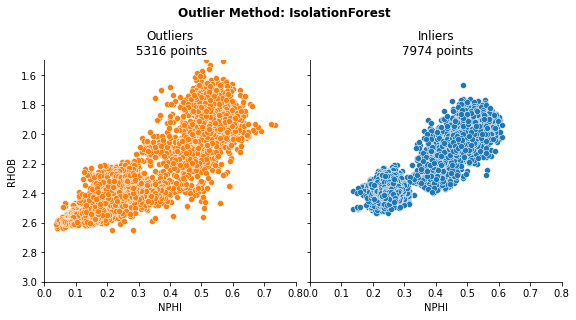

In [89]:
outlier_plot(df,"IsolationForest",'NPHI','RHOB',[0,0.8],[3,1.5])

### MAIS FEATURES

In [77]:
anomalias = ['NPHI','RHOB','GR','CALI','PEF','DTC']

In [78]:
model_IF = IsolationForest(contamination=0.1,random_state=42)
model_IF.fit(df[anomalias])
df['anomalias_scores'] = model_IF.decision_function(df[anomalias])
df['anoma'] = model_IF.predict(df[anomalias]) 

C:\Users\SAMUNEL\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


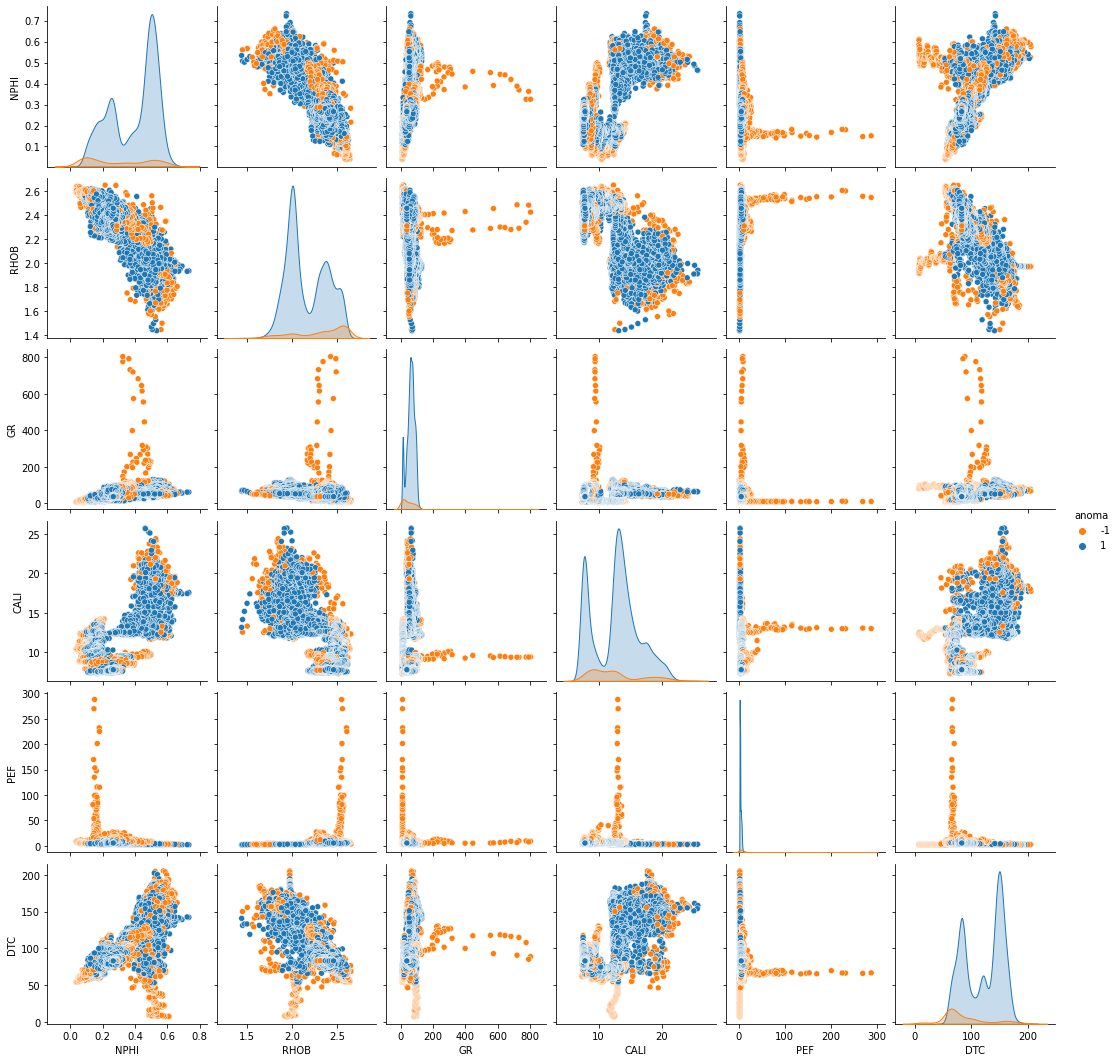

In [80]:
palette = ['#ff7f0e','#1F77B4']
sns.pairplot(df,vars=anomalias,hue = 'anoma',palette=palette)